# Import libraries and data

In [1]:
#import libraries
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from util import compute_IPEC_scores
from util import compute_diff_IPEC_scores
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import train_test_split

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import WeibullAFTFitter
from lifelines import AalenAdditiveFitter


In [2]:
#Define function to do the boxplot
def draw_plot(data, edge_color, fill_color, position):
    bp = ax.boxplot(data, positions = position, patch_artist=True, vert = False, showmeans = True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

In [3]:
# choose random seeds
np.random.seed(0)
seeds = np.random.permutation(1000)[:25]

In [5]:
#Import and discard NaN values
df_raw = sm.datasets.get_rdataset('pbc', 'survival').data
df_no_nans = df_raw.dropna()   #no nan values
df_no_nans = df_no_nans.drop('id', axis=1)  #first innecesary column
df_trans = df_no_nans['status'] 

In [6]:
# Only status 2 is an event
df_no_nans['status']=df_no_nans['status'].replace(1,False)      
df_no_nans['status']=df_no_nans['status'].replace(2,True) 
df_no_nans['status']=df_no_nans['status'].replace(0,False)
df_no_nans.head(8)

,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,400,True,1.0,58.765229,f,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,False,1.0,56.446270,f,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,True,1.0,70.072553,m,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,True,1.0,54.740589,f,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,False,2.0,38.105407,f,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
6,1832,False,2.0,55.534565,f,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0
7,2466,True,2.0,53.056810,f,0.0,0.0,0.0,0.0,0.3,280.0,4.00,52.0,4651.2,28.38,189.0,373.0,11.0,3.0
8,2400,True,1.0,42.507871,f,0.0,0.0,1.0,0.0,3.2,562.0,3.08,79.0,2276.0,144.15,88.0,251.0,11.0,2.0


In [7]:
#Get X and y from the data
from sksurv.datasets import get_x_y

X, y = get_x_y(df_no_nans, attr_labels=['status','time'], pos_label=True)

In [9]:
#Defining scalar and cathegorical columns
scaling_cols=['age','bili','chol','albumin','copper','alk.phos','ast','trig','platelet','protime']
cat_cols=['trt','edema','sex','ascites','hepato','spiders','stage']

In [10]:
#Preprocess the data
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    [('cat-preprocessor', OrdinalEncoder(), cat_cols),
    ('standard-scaler', StandardScaler(), scaling_cols)],
    remainder='passthrough', sparse_threshold=0)

In [3]:
#Read previous results to compare to the best models
df_ipec = pd.read_csv('ip_scores.csv')
nlc_ipec = df_ipec['DeepSurv']
cox_ipec = df_ipec['Cox PH*']
rsf_ipec = df_ipec['RSF*']

# Gradient Descent

In [22]:
# Best convex combination Gradient descent

def GradientDescent_multivariable (y_trn, y_val, survfunc1, survfunc2, survfunc3, survfunc4, survfunc5, survfunc6, times, tau, initial_lambda, rate, precision, max_iters):
    
    cur_lambda = initial_lambda
    iters = 0
    step_lambda = 1
    ipec_store = []
    cur_lambda_store = []

    while iters < max_iters:
        prev_lambda = cur_lambda
        survfunc = cur_lambda[0]*survfunc1 + cur_lambda[1]*survfunc2 + cur_lambda[2]*survfunc3 + cur_lambda[3]*survfunc4 +cur_lambda[4]*survfunc5 +cur_lambda[5]*survfunc6
        
        ip = compute_IPEC_scores(y_trn,y_val, times, survfunc,tau)
        ip = ip[tau[0]]/tau[0]
        
        ipec_store.append(ip)
        cur_lambda_store.append(cur_lambda[0])
        
        df_1 = compute_diff_IPEC_scores(y_trn, y_val, times, survfunc, survfunc1, tau)
        df_1 = df_1[tau[0]]/tau[0]
        
        df_2 = compute_diff_IPEC_scores(y_trn, y_val, times, survfunc, survfunc2, tau)
        df_2 = df_2[tau[0]]/tau[0]
        
        df_3 = compute_diff_IPEC_scores(y_trn, y_val, times, survfunc, survfunc3, tau)
        df_3 = df_3[tau[0]]/tau[0]
        
        df_4 = compute_diff_IPEC_scores(y_trn, y_val, times, survfunc, survfunc4, tau)
        df_4 = df_4[tau[0]]/tau[0]
        
        df_5 = compute_diff_IPEC_scores(y_trn, y_val, times, survfunc, survfunc5, tau)
        df_5 = df_5[tau[0]]/tau[0]
        
        df_6 = compute_diff_IPEC_scores(y_trn, y_val, times, survfunc, survfunc6, tau)
        df_6 = df_6[tau[0]]/tau[0]
        
        denom = cur_lambda[0]*np.exp(-rate*df_1) + cur_lambda[1]*np.exp(-rate*df_2) + cur_lambda[2]*np.exp(-rate*df_3) + cur_lambda[3]*np.exp(-rate*df_4) + cur_lambda[4]*np.exp(-rate*df_5) + cur_lambda[5]*np.exp(-rate*df_6)

        cur_lambda[0] = cur_lambda[0]*np.exp(-rate*df_1)/denom
        cur_lambda[1] = cur_lambda[1]*np.exp(-rate*df_2)/denom 
        cur_lambda[2] = cur_lambda[2]*np.exp(-rate*df_3)/denom
        cur_lambda[3] = cur_lambda[3]*np.exp(-rate*df_4)/denom
        cur_lambda[4] = cur_lambda[4]*np.exp(-rate*df_5)/denom
        cur_lambda[5] = cur_lambda[5]*np.exp(-rate*df_6)/denom
                
    
        iters = iters + 1
        
        
        
    survfunc = cur_lambda[0]*survfunc1 + cur_lambda[1]*survfunc2 + cur_lambda[2]*survfunc3 + cur_lambda[3]*survfunc4 + cur_lambda[4]*survfunc5 + cur_lambda[5]*survfunc6
    opt_ipec = compute_IPEC_scores(y_trn,y_val, times, survfunc,tau)
    opt_ipec = opt_ipec[tau[0]]/tau[0]
    
    ipec_store.append(opt_ipec)
    
    
    
    
    
    return opt_ipec, cur_lambda, ipec_store
    

# Multiple dataset splits

In [28]:
from sklearn.pipeline import make_pipeline

#Optimal hyperparameters
max_feature = 6
max_depth = 43
min_leaf = 8
alpha = 5.401

rng = np.random.RandomState(8)
multiple_scores = []

#For each seed
for _seed in seeds:
    
    #split the data
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
    #transform data
    X_trn1 = preprocessor.fit_transform(X_trn)
    X_val1 = preprocessor.transform(X_val)
    
    #cross validation training
    kf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=rng)
    
    #save weights
    lambda_store = []
    beta_store = []
    gamma_store = []
    delta_store = []
    alpha_store = []
    epsilon_store = []

    #splits of the training set for cross validation
    for train_idx, val_idx in kf.split(X_trn1):
        fold_X_trn = X_trn1[train_idx]
        fold_y_trn = y_trn[train_idx]
        fold_X_val = X_trn1[val_idx]
        fold_y_val = y_trn[val_idx]   
        
        #y_trn format
        y_trn_ip = np.zeros((len(fold_y_trn),2))
        y_val_ip = np.zeros((len(fold_y_val),2))
        for i in range(len(fold_y_trn)):
            y_trn_ip[i,0] = fold_y_trn['time'][i]
            y_trn_ip[i,1] = fold_y_trn['status'][i]
        
        for i in range(len(fold_y_val)):
            y_val_ip[i,0] = fold_y_val['time'][i]
            y_val_ip[i,1] = fold_y_val['status'][i]
    
        #train RSF
        rsf = RandomSurvivalForest(max_depth = max_depth, max_features = max_feature,min_samples_leaf = min_leaf, random_state=42)
        rsf.fit(fold_X_trn, fold_y_trn)
        rsf_survfunc_val = rsf.predict_survival_function(fold_X_val)
        x_axis = rsf.event_times_
    
        #train DeepSurv
        nlc = NonLinearCoxPHModel(structure=structure)
        nlc.fit(fold_X_trn, fold_y_trn["time"], fold_y_trn["status"])
        nlc_survfunc_val = nlc.predict_survival(fold_X_val)
        
        n2 = len(rsf_survfunc_val[0])
        rsf_survfunc_y = np.ones((len(fold_y_val),n2+1))
        rsf_times = np.zeros(n2+1)
        for i in range(n2):
            rsf_times[i+1] = x_axis[i]
        for j in range(len(fold_y_val)):
            for i in range(n2):
                rsf_survfunc_y[j,i+1] = rsf_survfunc_val[j][i]
    
        times = nlc.times
        tau = [times[-1]]
        times = np.concatenate(([0.], times))
        n = len(nlc_survfunc_val[0])
        nlc_survfunc_y = np.ones((len(fold_y_val),n+1))
    
        for j in range(len(fold_y_val)):
            for i in range(n):
                nlc_survfunc_y[j,i+1] = nlc_survfunc_val[j,i]
        
        #train Cox PH
        alpha = 5.401
        cox_ph = CoxPHSurvivalAnalysis(alpha)
        cox_ph.fit(fold_X_trn, fold_y_trn)
        cox_survfunc_val = cox_ph.predict_survival_function(fold_X_val)
    
        m = len(cox_survfunc_val[0].x)
        cox_survfunc_y = np.ones((len(fold_y_val),m+1))
        for j in range(len(fold_y_val)):
            for i in range(m):
                cox_survfunc_y[j,i+1] = cox_survfunc_val[j].y[i]
        
        cox_times = np.zeros(m+1)
        for i in range(m):
            cox_times[i+1] = cox_survfunc_val[0].x[i]
        
        new_cox_survfunc = np.ones((len(fold_y_val),n2+1))
        for k in range(len(fold_y_val)):
            for j in range(n2+1):
                for i in range(m+1):
                    if cox_times[i] == rsf_times[j]:
                        new_cox_survfunc[k,j] = cox_survfunc_y[k,i]
          
        #train GBC 
        gbc = GradientBoostingSurvivalAnalysis(random_state=42)
        gbc.fit(fold_X_trn, fold_y_trn)
        
        y_hat_train = gbc.predict(fold_X_trn).reshape(-1,1)
        y_hat_val = gbc.predict(fold_X_val).reshape(-1,1)
        cox_ph = CoxPHSurvivalAnalysis(alpha = 97.26)
        cox_ph.fit(y_hat_train, fold_y_trn)
        gbc_survfunc_val = cox_ph.predict_survival_function(y_hat_val)
            
        n = len(gbc_survfunc_val[0].x)
        gbc_survfunc_y = np.ones((len(fold_y_val),n+1))
        for j in range(len(fold_y_val)):
            for i in range(n):
                gbc_survfunc_y[j,i+1] = gbc_survfunc_val[j].y[i]
        
        gbc_times = np.zeros(n+1)
        for i in range(n):
            gbc_times[i+1] = gbc_survfunc_val[0].x[i]
        
        times = rsf_times
        tau = [times[-1]]
        new_gbc_survfunc = np.ones((len(fold_y_val),n2+1))

        for k in range(len(fold_y_val)):
            for j in range(n2+1):
                for i in range(n+1):
                    if gbc_times[i] == rsf_times[j]:
                        new_gbc_survfunc[k,j] = gbc_survfunc_y[k,i]
    
        #dataset format for lifelines libraries
        fold_X_trn2 = pd.DataFrame(fold_X_trn, columns=columns_encoded)
        fold_X_val2 = pd.DataFrame(fold_X_val, columns=columns_encoded)
        fold_X_trn2['status'] = fold_y_trn['status']
        fold_X_val2['status'] = fold_y_val['status']
        fold_X_trn2['time'] = fold_y_trn['time']
        fold_X_val2['time'] = fold_y_val['time']
        
        #train Weibull
        aft = WeibullAFTFitter()
        aft.fit(fold_X_trn2, duration_col='time', event_col='status')
        aft_survfunc_val = aft.predict_survival_function(fold_X_val2)
        
        n = len(aft_survfunc_val[0])
        aft_survfunc_yt = np.ones((len(fold_y_val),n))
        aft_survfunc_y = np.ones((len(fold_y_val),n+1))

        aft_times = np.zeros(n+1)
        timest = np.zeros(n)
        for i in range(n):
            timest[i] = aft_survfunc_val.index[i]

        for i in range(n):
            aft_times[i+1] = timest[i]
            
        for j in range(len(fold_y_val)):
            aft_survfunc_yt[j,:] = aft_survfunc_val.loc[:,j]
    
        for j in range (len(fold_y_val)):
            for i in range(n):
                aft_survfunc_y[j,i+1] = aft_survfunc_yt[j,i]
            
        new_aft_survfunc = np.ones((len(fold_y_val),n2+1))

        for k in range(len(fold_y_val)):
            for j in range(n2+1):
                for i in range(n+1):
                    if aft_times[i] == rsf_times[j]:
                        new_aft_survfunc[k,j] = aft_survfunc_y[k,i]
    
        #train Aalen
        aaf = AalenAdditiveFitter(coef_penalizer = 1)
        aaf.fit(fold_X_trn2, duration_col='time', event_col='status')
        aaf_survfunc_val = aaf.predict_survival_function(fold_X_val2)
        
        n = len(aaf_survfunc_val[0])
        aaf_survfunc_yt = np.ones((len(fold_y_val),n))
        aaf_survfunc_y = np.ones((len(fold_y_val),n+1))

        aaf_times = np.zeros(n+1)
        timest = np.zeros(n)
        for i in range(n):
            timest[i] = aaf_survfunc_val.index[i]

        for i in range(n):
            aaf_times[i+1] = timest[i]
    
        for j in range(len(fold_y_val)):
            aaf_survfunc_yt[j,:] = aaf_survfunc_val.loc[:,j]
    
        for j in range (len(fold_y_val)):
            for i in range(n):
                aaf_survfunc_y[j,i+1] = aaf_survfunc_yt[j,i]
        
        #gradient descent weights optimization
        initial_lambda = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
        [opt_ipec, cur_lambda, ipec_store] = GradientDescent_multivariable (y_trn_ip, y_val_ip, new_cox_survfunc, new_gbc_survfunc, rsf_survfunc_y, nlc_survfunc_y, new_aft_survfunc, aaf_survfunc_y, times, tau, initial_lambda, rate, precision, max_iters)
    
        
        lambda_store.append(cur_lambda[0])
        beta_store.append(cur_lambda[1])
        gamma_store.append(cur_lambda[2])
        delta_store.append(cur_lambda[3])
        alpha_store.append(cur_lambda[4])
        epsilon_store.append(cur_lambda[5])
    
    #we chose the average weight    
    lambda_min_score = np.mean(lambda_store)
    beta_min_score = np.mean(beta_store)
    gamma_min_score = np.mean(gamma_store)
    delta_min_score = np.mean(delta_store)
    alpha_min_score = np.mean(alpha_store)
    epsilon_min_score = np.mean(epsilon_store)
    
    #train the survival models to obtain the validation survival function
    nlc = NonLinearCoxPHModel(structure=structure)
    nlc.fit(X_trn1, y_trn["time"], y_trn["status"])

    rsf = RandomSurvivalForest(max_depth = max_depth, max_features = max_feature,min_samples_leaf = min_leaf, random_state=42)
    rsf.fit(X_trn1, y_trn)
    
    cox_ph = CoxPHSurvivalAnalysis(alpha)
    cox_ph.fit(X_trn1, y_trn)
    
    y_trn_ip = np.zeros((len(y_trn),2))
    y_val_ip = np.zeros((len(y_val),2))
    for i in range(len(y_trn)):
        y_trn_ip[i,0] = y_trn['time'][i]
        y_trn_ip[i,1] = y_trn['status'][i]     
    for i in range(len(y_val)):
        y_val_ip[i,0] = y_val['time'][i]
        y_val_ip[i,1] = y_val['status'][i]
         
    nlc_survfunc_val = nlc.predict_survival(X_val1)
    nlc_times = nlc.times
    nlc_times = np.concatenate(([0.], nlc_times))
    m = len(nlc_survfunc_val[0])
    nlc_survfunc_y = np.ones((69,m+1))
    for j in range (69):
        for i in range(m):
            nlc_survfunc_y[j,i+1] = nlc_survfunc_val[j,i]
            
    rsf_survfunc_trn = rsf.predict_survival_function(X_trn1)
    rsf_survfunc_val = rsf.predict_survival_function(X_val1)
    x_axis = rsf.event_times_
    n = len(rsf_survfunc_val[0])
    rsf_survfunc_y = np.ones((69,n+1))
    rsf_times = np.zeros(n+1)
    for i in range(n):
        rsf_times[i+1] = x_axis[i]

    for j in range(69):
        for i in range(n):
            rsf_survfunc_y[j,i+1] = rsf_survfunc_val[j][i]   
    
    cox_survfunc_val = cox_ph.predict_survival_function(X_val1)
    d = len(cox_survfunc_val[0].x)
    cox_survfunc_y = np.ones((69,d+1))
    for j in range(69):
        for i in range(d):
            cox_survfunc_y[j,i+1] = cox_survfunc_val[j].y[i]  
    cox_times = np.zeros(d+1)
    for i in range(d):
        cox_times[i+1] = cox_survfunc_val[0].x[i]
     
    times = nlc_times
    tau = [times[-1]]
    
    new_cox_survfunc = np.ones((69,m+1))
    for k in range(69):
        for j in range(m+1):
            for i in range(d+1):
                if cox_times[i] == rsf_times[j]:
                    new_cox_survfunc[k,j] = cox_survfunc_y[k,i]
    
    gbc = GradientBoostingSurvivalAnalysis(random_state=42)
    gbc.fit(X_trn1, y_trn)
    
    y_hat_train = gbc.predict(X_trn1).reshape(-1,1)
    y_hat_val = gbc.predict(X_val1).reshape(-1,1)

    cox_ph = CoxPHSurvivalAnalysis(alpha = 97.26)
    cox_ph.fit(y_hat_train, y_trn)

    gbc_survfunc_val = cox_ph.predict_survival_function(y_hat_val)
    
    n = len(gbc_survfunc_val[0].x)
    gbc_survfunc_y = np.ones((69,n+1))
    for j in range(69):
        for i in range(n):
            gbc_survfunc_y[j,i+1] = gbc_survfunc_val[j].y[i]
        
    gbc_times = np.zeros(n+1)
    for i in range(n):
        gbc_times[i+1] = gbc_survfunc_val[0].x[i]
        
        
    new_gbc_survfunc = np.ones((69,m+1))

    for k in range(69):
        for j in range(m+1):
            for i in range(n+1):
                if gbc_times[i] == rsf_times[j]:
                    new_gbc_survfunc[k,j] = gbc_survfunc_y[k,i]
                

    columns_encoded = X_trn.columns

    X_trn2 = pd.DataFrame(X_trn1, columns=columns_encoded)
    X_val2 = pd.DataFrame(X_val1, columns=columns_encoded)

    X_trn2['status'] = y_trn['status']
    X_val2['status'] = y_val['status']
    X_trn2['time'] = y_trn['time']
    X_val2['time'] = y_val['time']
    
    aft = WeibullAFTFitter()
    aft.fit(X_trn2, duration_col='time', event_col='status')

    aft_survfunc_val = aft.predict_survival_function(X_val2)
    
    n = len(aft_survfunc_val[0])
    aft_survfunc_yt = np.ones((69,n))
    aft_survfunc_y = np.ones((69,n+1))

    aft_times = np.zeros(n+1)
    timest = np.zeros(n)
    for i in range(n):
        timest[i] = aft_survfunc_val.index[i]
    
    for i in range(n):
        aft_times[i+1] = timest[i]

    for j in range(69):
        aft_survfunc_yt[j,:] = aft_survfunc_val.loc[:,j]
    
    for j in range (69):
        for i in range(n):
            aft_survfunc_y[j,i+1] = aft_survfunc_yt[j,i]
        
    new_aft_survfunc = np.ones((69,m+1))

    for k in range(69):
        for j in range(m+1):
            for i in range(n+1):
                if aft_times[i] == rsf_times[j]:
                    new_aft_survfunc[k,j] = aft_survfunc_y[k,i]
        
        
    aaf = AalenAdditiveFitter(coef_penalizer = 1)
    aaf.fit(X_trn2,'time', event_col='status')

    aaf_survfunc_val = aaf.predict_survival_function(X_val2)
    
    n = len(aaf_survfunc_val[0])
    aaf_survfunc_yt = np.ones((69,n))
    aaf_survfunc_y = np.ones((69,n+1))

    aaf_times = np.zeros(n+1)
    timest = np.zeros(n)
    for i in range(n):
        timest[i] = aaf_survfunc_val.index[i]

    for i in range(n):
        aaf_times[i+1] = timest[i]

    for j in range(69):
        aaf_survfunc_yt[j,:] = aaf_survfunc_val.loc[:,j]
    
    for j in range (69):
        for i in range(n):
            aaf_survfunc_y[j,i+1] = aaf_survfunc_yt[j,i]
    
    #agregate survival functions
    survfunc = lambda_min_score*new_cox_survfunc + beta_min_score*new_gbc_survfunc + gamma_min_score*rsf_survfunc_y + delta_min_score*nlc_survfunc_y + alpha_min_score*new_aft_survfunc   + epsilon_min_score*aaf_survfunc_y  
    
    #scor of the aggregation
    ip = compute_IPEC_scores(y_trn_ip, y_val_ip, times, survfunc, tau)
    ip_score = ip[tau[0]]/ tau[0]
    
    multiple_scores.append(ip_score)

C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 218.24
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 221.33
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 237.64
C:\Users\camferna\Anaconda3\lib\site-packag

C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 248.47
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 205.61
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 243.72
C:\Users\camferna\Anaconda3\lib\site-packag

C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 206.63
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 215.87
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 188.30
C:\Users\camferna\Anaconda3\lib\site-packag

C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 257.56
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 244.08
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 223.03
C:\Users\camferna\Anaconda3\lib\site-packag

C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 254.02
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 232.95
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 295.00
C:\Users\camferna\Anaconda3\lib\site-packag

C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 231.37
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 218.71
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 215.51
C:\Users\camferna\Anaconda3\lib\site-packag

C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 224.24
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 216.74
C:\Users\camferna\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
% Completion: 100%|***********************************************|Loss: 244.96
C:\Users\camferna\Anaconda3\lib\site-packag

In [31]:
print(f'The IPEC score of the combination of all the models is given by {np.mean(multiple_scores):.3f}')

The IPEC score of the combination of all the models is given by 0.162


In [32]:
#Save results in a csv 
df_csv = pd.read_csv('ip_gradient_scores.csv')
df_csv['allGD'] = pd.Series(multiple_scores)
df_csv.to_csv('ip_gradient_scores.csv', mode='w')

# Results graph

C:\Users\camferna\AppData\Local\Temp/ipykernel_16332/1239158312.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0.05','0.1','0.15','0.2','0.25','0.3'], fontsize = 20)


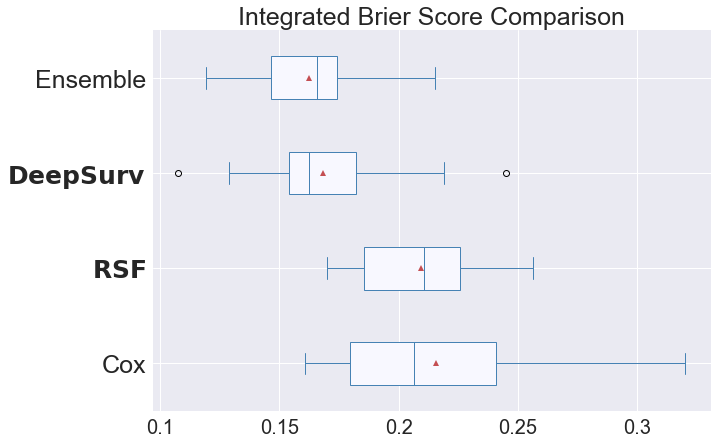

The IPEC score of all the models with GD is given by 0.162
The IPEC score of Cox is given by 0.216
The IPEC score of DeepSurv is given by 0.168
The IPEC score of RSF is given by 0.209


In [5]:
fig, ax = plt.subplots(figsize=(10,7))


df_csv = pd.read_csv('ip_gradient_scores.csv')
multiple_scores = df_csv['allGD']


data = [nlc_ipec, cox_ipec, multiple_scores, rsf_ipec]

draw_plot(data, 'steelblue', 'ghostwhite', [3,1,4,2])
ax.set_yticklabels([r'$\bf{DeepSurv}$','Cox','Ensemble',r'$\bf{RSF}$'], fontsize = 25)
ax.set_xticklabels(['0.05','0.1','0.15','0.2','0.25','0.3'], fontsize = 20)
plt.title('Integrated Brier Score Comparison', fontsize = 25)
plt.show()

#print(f'The IPEC score of RSF + DeepSurv + Cox with GD is given by {np.mean(rsf_nlc_cox):.3f}')
print(f'The IPEC score of all the models with GD is given by {np.mean(multiple_scores):.3f}')
print(f'The IPEC score of Cox is given by {np.mean(cox_ipec):.3f}')
print(f'The IPEC score of DeepSurv is given by {np.mean(nlc_ipec):.3f}')
print(f'The IPEC score of RSF is given by {np.mean(rsf_ipec):.3f}')